# Predicting house prices using Pytorch
In this notebook, we will use the processed data from the Dutch House Prices Dataset in order to train Deep Learning model to predict house prices. We demonstrate the model construction and learning process, and we try to further optimize our models. In total, 60 models have been trained and compared.

This notebook is part of my House Price series in which we create a dataset, train a prediction model, and deploy the model and an accompanying web app.

© Bryan Lusse - 2022

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.notebook import tqdm

import os

## Read processed data
We use the data that has been processed in the [*data_processing*](/data_processing.ipynb) notebook

In [2]:
df = pd.read_csv('datasets/processed_data.csv')

## Turn dataframes into Torch dataset
We turn our data into tensors, and split the data into input and target data

In [3]:
output_col = ['Price']
input_cols = ['City', 'Lot size (m2)', 'Living space size (m2)', 'Build year',
              'Build type', 'House type', 'Roof', 'Rooms', 'Toilet', 'Floors',
              'Energy label', 'Position', 'Garden',
              'Estimated neighbourhood price per m2']

def dataframe_to_arrays(df):
    # Make a copy of the original dataset
    dataframe = df.copy(deep = True)

    # Extract input & outputs as numpy arrays
    input_array = dataframe[input_cols].to_numpy()
    target_array = dataframe[output_col].to_numpy()
    return input_array, target_array.reshape((len(df), 1))

input_array_tot, target_array_tot = dataframe_to_arrays(df)

In [4]:
inputs_tot = torch.Tensor(input_array_tot)
targets_tot = torch.Tensor(target_array_tot)

print(inputs_tot.shape)
print(targets_tot.shape)

torch.Size([5296, 14])
torch.Size([5296, 1])


### Split data
We use a 70/15/15 split for our data into training, validation and testing respectively. 

Additionally, we create a dataloader to load training, validation and testing data incrementally. 

In [5]:
dataset_tot = TensorDataset(inputs_tot, targets_tot)
num_entries = len(df)

val_percent = 0.15
test_percent = 0.15

val_size = int(num_entries * val_percent)
test_size = int(num_entries * test_percent)
train_size = num_entries - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset_tot, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(424))

In [6]:
train_size, val_size, test_size

(3708, 794, 794)

In [7]:
batch_size = 64

train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size)

## Model Definition
We use a fully connected neural network for our predictions. We do this since our models only need to deal with pure numerical data. We do not need convolutions as we have no image data, and no attention or memory layers as we do not use text data with complex connections.

In [8]:
input_size = len(input_cols)
output_size = len(output_col)

### Neural network
The _Net_ class consists of fully connected layers who's shape is dependent on the amount of layers the model has. To make our lives easier, and to use less code, we programmed the network to be adaptable to different amounts of layers. This is an important characteristic and different values should be tested in order to achieve the best model.

In [10]:
class Net(nn.Module):
    def __init__(self, layers, input_shape, output_shape):
        super(Net, self).__init__()
        self.layers = layers
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.shapes = np.append(np.linspace(input_shape, output_shape,layers, endpoint=False).round(),output_shape).astype(int)
        self.fc_layers = nn.ModuleList()  
        for layer in range(layers):
            self.fc_layers.append(nn.Linear(self.shapes[layer], self.shapes[layer+1]))

    # x represents our data
    def forward(self, x):
        # Pass data through fc1
        for layer in range(self.layers):
            x = self.fc_layers[layer](x)
            x = F.relu(x)

        output = x
        return output
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.mse_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.mse_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, loss, num_epochs):
        # Print result every 50th epoch
        if (epoch+1) % 50 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}, loss: {:.4f}".format(epoch+1, result['val_loss'], loss['loss']))

## Training
Additionally, we define some functions to perform the training process

In [12]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, filename, opt_func = torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        running_loss = []
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss.append(loss)
            
        # Validation phase
        running_loss = torch.stack(running_loss).mean()
        result = evaluate(model, val_loader)
        training_result = {'loss': running_loss.detach()}
        model.epoch_end(epoch, result, training_result, epochs)
        history.append({**result,**training_result})
        if epoch == 0:
            performance = result['val_loss']
            torch.save(model.state_dict(), filename+'_best-model-parameters.pt')
        elif result['val_loss'] < performance:
            torch.save(model.state_dict(), filename+'_best-model-parameters.pt')
             
    return history

### Neural networks
As mentioned, we use models that differ in the amount of layers used. We train models with one layer (essentially a linear model), two layers and three layers. These models are visualized in the images below.

<p align="middle">
  <img src="assets/nn_1.png" width="300" />
  <img src="assets/nn_2.png" width="300" /> 
  <img src="assets/nn_3.png" width="300" />
</p>

Where, blue and red lines signify negative and positive weights respectively.

We use multiple values for the learning rate and perform every experiment three times, to reduce the effect of local minimums and bad optimization in the optimizers

In [19]:
# initialize model and optimizer every run

model_names = ['3-layers', '2-layers', '1-layer']
model_outputs = []
epochs = 5000
lrs = [0.0001, 0.001, 0.01]
histories = []
nr_experiments = 3
for i in tqdm(range(nr_experiments), total=nr_experiments):
    for lr in lrs:
        for model_name in tqdm(model_names, total=len(model_names), leave=False):
            model = Net(int(model_name[0]), input_size, output_size)
            print('Starting training of model: {0} with Lr: {1}'.format(model_name,lr))
            history = fit(epochs, lr, model, train_loader, val_loader, filename='results/nn/'+model_name+'_'+str(lr)+'_'+str(i))
            histories.append(history)
            


  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.0001
Epoch [50], val_loss: 12.1785, loss: 12.0408
Epoch [100], val_loss: 11.7946, loss: 11.6881
Epoch [150], val_loss: 11.3482, loss: 11.2783
Epoch [200], val_loss: 10.6866, loss: 10.6412
Epoch [250], val_loss: 9.5829, loss: 9.5876
Epoch [300], val_loss: 8.0302, loss: 8.0511
Epoch [350], val_loss: 6.8962, loss: 6.8858
Epoch [400], val_loss: 6.4014, loss: 6.3096
Epoch [450], val_loss: 6.1761, loss: 6.0157
Epoch [500], val_loss: 6.0581, loss: 5.8436
Epoch [550], val_loss: 5.9793, loss: 5.7298
Epoch [600], val_loss: 5.9258, loss: 5.6423
Epoch [650], val_loss: 5.8833, loss: 5.5755
Epoch [700], val_loss: 5.8443, loss: 5.5181
Epoch [750], val_loss: 5.8116, loss: 5.4748
Epoch [800], val_loss: 5.7821, loss: 5.4298
Epoch [850], val_loss: 5.7580, loss: 5.3941
Epoch [900], val_loss: 5.7388, loss: 5.3573
Epoch [950], val_loss: 5.7201, loss: 5.3300
Epoch [1000], val_loss: 5.7040, loss: 5.2926
Epoch [1050], val_loss: 5.6975, loss: 5.2660
Epoch [1100], 


  4%|████▎                                                                                                                | 1/27 [04:04<1:45:44, 244.01s/it]

Epoch [5000], val_loss: 5.3533, loss: 4.7924
Starting training of model: 2-layers with Lr: 0.0001
Epoch [50], val_loss: 11.5883, loss: 11.6350
Epoch [100], val_loss: 11.0666, loss: 11.1291
Epoch [150], val_loss: 10.5342, loss: 10.6173
Epoch [200], val_loss: 9.9701, loss: 10.0692
Epoch [250], val_loss: 9.3718, loss: 9.4669
Epoch [300], val_loss: 8.7650, loss: 8.8706
Epoch [350], val_loss: 8.1945, loss: 8.2962
Epoch [400], val_loss: 7.7034, loss: 7.7696
Epoch [450], val_loss: 7.3120, loss: 7.3675
Epoch [500], val_loss: 7.0160, loss: 7.0225
Epoch [550], val_loss: 6.7959, loss: 6.7725
Epoch [600], val_loss: 6.6315, loss: 6.5733
Epoch [650], val_loss: 6.5061, loss: 6.4319
Epoch [700], val_loss: 6.4084, loss: 6.2936
Epoch [750], val_loss: 6.3301, loss: 6.1837
Epoch [800], val_loss: 6.2675, loss: 6.1000
Epoch [850], val_loss: 6.2169, loss: 6.0252
Epoch [900], val_loss: 6.1756, loss: 5.9641
Epoch [950], val_loss: 6.1407, loss: 5.9083
Epoch [1000], val_loss: 6.1111, loss: 5.8662
Epoch [1050], v


  7%|████████▋                                                                                                            | 2/27 [07:41<1:35:07, 228.31s/it]

Epoch [5000], val_loss: 5.6803, loss: 5.2323
Starting training of model: 1-layer with Lr: 0.0001
Epoch [50], val_loss: 13.4059, loss: 13.4560
Epoch [100], val_loss: 11.6797, loss: 11.7264
Epoch [150], val_loss: 11.4302, loss: 11.4926
Epoch [200], val_loss: 11.2685, loss: 11.3391
Epoch [250], val_loss: 11.1174, loss: 11.1896
Epoch [300], val_loss: 10.9720, loss: 11.0520
Epoch [350], val_loss: 10.8318, loss: 10.9170
Epoch [400], val_loss: 10.6966, loss: 10.7768
Epoch [450], val_loss: 10.5662, loss: 10.6514
Epoch [500], val_loss: 10.4403, loss: 10.5279
Epoch [550], val_loss: 10.3188, loss: 10.4079
Epoch [600], val_loss: 10.2016, loss: 10.2934
Epoch [650], val_loss: 10.0884, loss: 10.1884
Epoch [700], val_loss: 9.9790, loss: 10.0750
Epoch [750], val_loss: 9.8734, loss: 9.9757
Epoch [800], val_loss: 9.7714, loss: 9.8683
Epoch [850], val_loss: 9.6729, loss: 9.7956
Epoch [900], val_loss: 9.5777, loss: 9.6782
Epoch [950], val_loss: 9.4856, loss: 9.5851
Epoch [1000], val_loss: 9.3967, loss: 9.4

 11%|█████████████                                                                                                        | 3/27 [10:52<1:26:56, 217.36s/it]


Epoch [5000], val_loss: 6.7312, loss: 6.6990



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.001
Epoch [50], val_loss: 6.5335, loss: 6.3845
Epoch [100], val_loss: 5.7690, loss: 5.3384
Epoch [150], val_loss: 5.5696, loss: 5.0724
Epoch [200], val_loss: 5.4156, loss: 4.9453
Epoch [250], val_loss: 5.3288, loss: 4.8885
Epoch [300], val_loss: 5.2940, loss: 4.8101
Epoch [350], val_loss: 5.2795, loss: 4.7819
Epoch [400], val_loss: 5.2282, loss: 4.7322
Epoch [450], val_loss: 5.2259, loss: 4.7146
Epoch [500], val_loss: 5.2068, loss: 4.6709
Epoch [550], val_loss: 5.2406, loss: 4.6449
Epoch [600], val_loss: 5.3118, loss: 4.5886
Epoch [650], val_loss: 5.1888, loss: 4.5734
Epoch [700], val_loss: 5.1422, loss: 4.5514
Epoch [750], val_loss: 5.0899, loss: 4.5048
Epoch [800], val_loss: 5.1070, loss: 4.4901
Epoch [850], val_loss: 5.0878, loss: 4.4686
Epoch [900], val_loss: 5.1083, loss: 4.4503
Epoch [950], val_loss: 5.3204, loss: 4.4504
Epoch [1000], val_loss: 5.2129, loss: 4.4177
Epoch [1050], val_loss: 5.1513, loss: 4.4339
Epoch [1100], val_loss:


  4%|████▎                                                                                                                | 1/27 [04:01<1:44:43, 241.68s/it]

Epoch [5000], val_loss: 7.2630, loss: 3.2985
Starting training of model: 2-layers with Lr: 0.001
Epoch [50], val_loss: 43.3170, loss: 42.8708
Epoch [100], val_loss: 43.3170, loss: 42.8647
Epoch [150], val_loss: 43.3170, loss: 42.8981
Epoch [200], val_loss: 43.3170, loss: 42.8732
Epoch [250], val_loss: 43.3170, loss: 42.8538
Epoch [300], val_loss: 43.3170, loss: 42.8570
Epoch [350], val_loss: 43.3170, loss: 42.8794
Epoch [400], val_loss: 43.3170, loss: 42.8605
Epoch [450], val_loss: 43.3170, loss: 42.8786
Epoch [500], val_loss: 43.3170, loss: 42.8958
Epoch [550], val_loss: 43.3170, loss: 42.9061
Epoch [600], val_loss: 43.3170, loss: 42.8622
Epoch [650], val_loss: 43.3170, loss: 42.8706
Epoch [700], val_loss: 43.3170, loss: 42.8572
Epoch [750], val_loss: 43.3170, loss: 42.8698
Epoch [800], val_loss: 43.3170, loss: 42.8807
Epoch [850], val_loss: 43.3170, loss: 42.8632
Epoch [900], val_loss: 43.3170, loss: 42.8540
Epoch [950], val_loss: 43.3170, loss: 42.8671
Epoch [1000], val_loss: 43.317


  7%|████████▋                                                                                                            | 2/27 [07:33<1:33:18, 223.96s/it]

Epoch [5000], val_loss: 43.3170, loss: 42.8949
Starting training of model: 1-layer with Lr: 0.001
Epoch [50], val_loss: 10.4673, loss: 10.6110
Epoch [100], val_loss: 9.4147, loss: 9.5643
Epoch [150], val_loss: 8.6645, loss: 8.8140
Epoch [200], val_loss: 8.1199, loss: 8.2533
Epoch [250], val_loss: 7.7168, loss: 7.8206
Epoch [300], val_loss: 7.4125, loss: 7.5045
Epoch [350], val_loss: 7.1783, loss: 7.2463
Epoch [400], val_loss: 6.9946, loss: 7.0309
Epoch [450], val_loss: 6.8480, loss: 6.8614
Epoch [500], val_loss: 6.7296, loss: 6.7230
Epoch [550], val_loss: 6.6318, loss: 6.6081
Epoch [600], val_loss: 6.5508, loss: 6.5253
Epoch [650], val_loss: 6.4824, loss: 6.4185
Epoch [700], val_loss: 6.4241, loss: 6.3613
Epoch [750], val_loss: 6.3744, loss: 6.2786
Epoch [800], val_loss: 6.3311, loss: 6.2381
Epoch [850], val_loss: 6.2930, loss: 6.1719
Epoch [900], val_loss: 6.2600, loss: 6.1283
Epoch [950], val_loss: 6.2306, loss: 6.0828
Epoch [1000], val_loss: 6.2045, loss: 6.0450
Epoch [1050], val_lo

 11%|█████████████                                                                                                        | 3/27 [10:42<1:25:40, 214.18s/it]


Epoch [5000], val_loss: 5.7403, loss: 5.3745



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.01
Epoch [50], val_loss: 43.3170, loss: 42.8622
Epoch [100], val_loss: 43.3170, loss: 42.8552
Epoch [150], val_loss: 43.3170, loss: 42.8721
Epoch [200], val_loss: 43.3170, loss: 42.8620
Epoch [250], val_loss: 43.3170, loss: 42.8613
Epoch [300], val_loss: 43.3170, loss: 42.8508
Epoch [350], val_loss: 43.3170, loss: 42.8580
Epoch [400], val_loss: 43.3170, loss: 42.8891
Epoch [450], val_loss: 43.3170, loss: 42.8659
Epoch [500], val_loss: 43.3170, loss: 42.8685
Epoch [550], val_loss: 43.3170, loss: 42.8861
Epoch [600], val_loss: 43.3170, loss: 42.8904
Epoch [650], val_loss: 43.3170, loss: 42.9425
Epoch [700], val_loss: 43.3170, loss: 42.9077
Epoch [750], val_loss: 43.3170, loss: 42.8618
Epoch [800], val_loss: 43.3170, loss: 42.8726
Epoch [850], val_loss: 43.3170, loss: 42.8770
Epoch [900], val_loss: 43.3170, loss: 42.8517
Epoch [950], val_loss: 43.3170, loss: 42.8741
Epoch [1000], val_loss: 43.3170, loss: 42.8842
Epoch [1050], val_loss: 43.31


  4%|████▎                                                                                                                | 1/27 [03:55<1:42:03, 235.51s/it]

Epoch [5000], val_loss: 43.3170, loss: 42.8744
Starting training of model: 2-layers with Lr: 0.01
Epoch [50], val_loss: 5.6311, loss: 5.3218
Epoch [100], val_loss: 5.5888, loss: 4.9871
Epoch [150], val_loss: 5.4454, loss: 4.8400
Epoch [200], val_loss: 5.4102, loss: 4.7976
Epoch [250], val_loss: 5.3283, loss: 4.7725
Epoch [300], val_loss: 5.3868, loss: 4.7534
Epoch [350], val_loss: 5.3207, loss: 4.6552
Epoch [400], val_loss: 5.3477, loss: 4.6472
Epoch [450], val_loss: 5.4632, loss: 4.6437
Epoch [500], val_loss: 5.3047, loss: 4.5970
Epoch [550], val_loss: 5.3475, loss: 4.5519
Epoch [600], val_loss: 5.4201, loss: 4.4994
Epoch [650], val_loss: 5.4673, loss: 4.4943
Epoch [700], val_loss: 5.3343, loss: 4.4987
Epoch [750], val_loss: 5.3226, loss: 4.4684
Epoch [800], val_loss: 5.3274, loss: 4.3959
Epoch [850], val_loss: 5.2674, loss: 4.3153
Epoch [900], val_loss: 5.4321, loss: 4.3144
Epoch [950], val_loss: 5.3429, loss: 4.2900
Epoch [1000], val_loss: 5.3411, loss: 4.3029
Epoch [1050], val_loss


  7%|████████▋                                                                                                            | 2/27 [07:32<1:33:37, 224.71s/it]

Epoch [5000], val_loss: 5.9742, loss: 4.0453
Starting training of model: 1-layer with Lr: 0.01
Epoch [50], val_loss: 6.7624, loss: 6.7619
Epoch [100], val_loss: 6.2272, loss: 6.0650
Epoch [150], val_loss: 6.0585, loss: 5.8184
Epoch [200], val_loss: 5.9695, loss: 5.6912
Epoch [250], val_loss: 5.9055, loss: 5.5892
Epoch [300], val_loss: 5.8600, loss: 5.5218
Epoch [350], val_loss: 5.8194, loss: 5.4716
Epoch [400], val_loss: 5.7866, loss: 5.4288
Epoch [450], val_loss: 5.7618, loss: 5.3938
Epoch [500], val_loss: 5.7422, loss: 5.3703
Epoch [550], val_loss: 5.7292, loss: 5.3505
Epoch [600], val_loss: 5.7226, loss: 5.3231
Epoch [650], val_loss: 5.7071, loss: 5.3181
Epoch [700], val_loss: 5.7003, loss: 5.3100
Epoch [750], val_loss: 5.6959, loss: 5.2929
Epoch [800], val_loss: 5.6934, loss: 5.2809
Epoch [850], val_loss: 5.6897, loss: 5.2844
Epoch [900], val_loss: 5.6888, loss: 5.2689
Epoch [950], val_loss: 5.6877, loss: 5.2659
Epoch [1000], val_loss: 5.6888, loss: 5.2638
Epoch [1050], val_loss: 5

 11%|█████████████                                                                                                        | 3/27 [10:42<1:25:38, 214.10s/it]


Epoch [5000], val_loss: 5.7075, loss: 5.2467



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.0001
Epoch [50], val_loss: 12.0718, loss: 12.0182
Epoch [100], val_loss: 11.6429, loss: 11.6083
Epoch [150], val_loss: 11.1282, loss: 11.1243
Epoch [200], val_loss: 10.3740, loss: 10.4047
Epoch [250], val_loss: 9.1747, loss: 9.2430
Epoch [300], val_loss: 7.6842, loss: 7.7449
Epoch [350], val_loss: 6.7617, loss: 6.7567
Epoch [400], val_loss: 6.3620, loss: 6.2751
Epoch [450], val_loss: 6.1418, loss: 5.9916
Epoch [500], val_loss: 6.0161, loss: 5.8136
Epoch [550], val_loss: 5.9481, loss: 5.6936
Epoch [600], val_loss: 5.9045, loss: 5.6066
Epoch [650], val_loss: 5.8700, loss: 5.5348
Epoch [700], val_loss: 5.8330, loss: 5.4858
Epoch [750], val_loss: 5.8042, loss: 5.4237
Epoch [800], val_loss: 5.7754, loss: 5.3779
Epoch [850], val_loss: 5.7533, loss: 5.3408
Epoch [900], val_loss: 5.7336, loss: 5.3059
Epoch [950], val_loss: 5.7178, loss: 5.2703
Epoch [1000], val_loss: 5.7039, loss: 5.2395
Epoch [1050], val_loss: 5.6938, loss: 5.2096
Epoch [1100], 


  4%|████▎                                                                                                                | 1/27 [04:01<1:44:34, 241.34s/it]

Epoch [5000], val_loss: 5.2838, loss: 4.6623
Starting training of model: 2-layers with Lr: 0.0001
Epoch [50], val_loss: 11.6436, loss: 11.6964
Epoch [100], val_loss: 11.1639, loss: 11.2350
Epoch [150], val_loss: 10.6708, loss: 10.7554
Epoch [200], val_loss: 10.1401, loss: 10.2361
Epoch [250], val_loss: 9.5674, loss: 9.6740
Epoch [300], val_loss: 8.9686, loss: 9.0870
Epoch [350], val_loss: 8.3820, loss: 8.4882
Epoch [400], val_loss: 7.8557, loss: 7.9491
Epoch [450], val_loss: 7.4238, loss: 7.4865
Epoch [500], val_loss: 7.0925, loss: 7.1273
Epoch [550], val_loss: 6.8482, loss: 6.8663
Epoch [600], val_loss: 6.6692, loss: 6.6437
Epoch [650], val_loss: 6.5354, loss: 6.4811
Epoch [700], val_loss: 6.4341, loss: 6.3505
Epoch [750], val_loss: 6.3560, loss: 6.2442
Epoch [800], val_loss: 6.2929, loss: 6.1565
Epoch [850], val_loss: 6.2432, loss: 6.0851
Epoch [900], val_loss: 6.2023, loss: 6.0230
Epoch [950], val_loss: 6.1686, loss: 5.9664
Epoch [1000], val_loss: 6.1397, loss: 5.9199
Epoch [1050], 


  7%|████████▋                                                                                                            | 2/27 [08:02<1:40:31, 241.27s/it]

Epoch [5000], val_loss: 5.6216, loss: 5.1315
Starting training of model: 1-layer with Lr: 0.0001
Epoch [50], val_loss: 13.5350, loss: 13.6258
Epoch [100], val_loss: 11.6142, loss: 11.7011
Epoch [150], val_loss: 11.3578, loss: 11.4536
Epoch [200], val_loss: 11.1987, loss: 11.3030
Epoch [250], val_loss: 11.0504, loss: 11.1539
Epoch [300], val_loss: 10.9076, loss: 11.0596
Epoch [350], val_loss: 10.7700, loss: 10.8762
Epoch [400], val_loss: 10.6372, loss: 10.7497
Epoch [450], val_loss: 10.5090, loss: 10.6216
Epoch [500], val_loss: 10.3853, loss: 10.5061
Epoch [550], val_loss: 10.2659, loss: 10.3830
Epoch [600], val_loss: 10.1507, loss: 10.2824
Epoch [650], val_loss: 10.0394, loss: 10.1816
Epoch [700], val_loss: 9.9318, loss: 10.0536
Epoch [750], val_loss: 9.8280, loss: 9.9518
Epoch [800], val_loss: 9.7276, loss: 9.8548
Epoch [850], val_loss: 9.6307, loss: 9.7609
Epoch [900], val_loss: 9.5370, loss: 9.7109
Epoch [950], val_loss: 9.4464, loss: 9.5725
Epoch [1000], val_loss: 9.3588, loss: 9.4

 11%|█████████████                                                                                                        | 3/27 [11:11<1:29:31, 223.80s/it]


Epoch [5000], val_loss: 6.7195, loss: 6.7027



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.001
Epoch [50], val_loss: 6.1271, loss: 5.9317
Epoch [100], val_loss: 5.7584, loss: 5.4032
Epoch [150], val_loss: 5.6890, loss: 5.2854
Epoch [200], val_loss: 5.6879, loss: 5.2706
Epoch [250], val_loss: 5.7113, loss: 5.2471
Epoch [300], val_loss: 5.7388, loss: 5.2476
Epoch [350], val_loss: 5.6856, loss: 5.2511
Epoch [400], val_loss: 5.7256, loss: 5.2406
Epoch [450], val_loss: 5.6856, loss: 5.2141
Epoch [500], val_loss: 5.6789, loss: 5.1984
Epoch [550], val_loss: 5.6725, loss: 5.1708
Epoch [600], val_loss: 5.6324, loss: 5.1399
Epoch [650], val_loss: 5.6209, loss: 5.0961
Epoch [700], val_loss: 5.5876, loss: 5.0439
Epoch [750], val_loss: 5.5713, loss: 5.0065
Epoch [800], val_loss: 5.5071, loss: 4.9480
Epoch [850], val_loss: 5.4918, loss: 4.8895
Epoch [900], val_loss: 5.4734, loss: 4.8632
Epoch [950], val_loss: 5.4457, loss: 4.8234
Epoch [1000], val_loss: 5.4010, loss: 4.7905
Epoch [1050], val_loss: 5.3990, loss: 4.7644
Epoch [1100], val_loss:


  4%|████▎                                                                                                                | 1/27 [04:03<1:45:23, 243.20s/it]

Epoch [5000], val_loss: 5.6329, loss: 3.8757
Starting training of model: 2-layers with Lr: 0.001
Epoch [50], val_loss: 43.3170, loss: 42.8819
Epoch [100], val_loss: 43.3170, loss: 42.8716
Epoch [150], val_loss: 43.3170, loss: 42.8687
Epoch [200], val_loss: 43.3170, loss: 42.8532
Epoch [250], val_loss: 43.3170, loss: 42.8611
Epoch [300], val_loss: 43.3170, loss: 42.8691
Epoch [350], val_loss: 43.3170, loss: 42.8811
Epoch [400], val_loss: 43.3170, loss: 42.8699
Epoch [450], val_loss: 43.3170, loss: 42.8612
Epoch [500], val_loss: 43.3170, loss: 42.8918
Epoch [550], val_loss: 43.3170, loss: 42.8809
Epoch [600], val_loss: 43.3170, loss: 42.8541
Epoch [650], val_loss: 43.3170, loss: 42.8668
Epoch [700], val_loss: 43.3170, loss: 42.8672
Epoch [750], val_loss: 43.3170, loss: 42.8664
Epoch [800], val_loss: 43.3170, loss: 42.8763
Epoch [850], val_loss: 43.3170, loss: 42.8899
Epoch [900], val_loss: 43.3170, loss: 42.8784
Epoch [950], val_loss: 43.3170, loss: 42.8914
Epoch [1000], val_loss: 43.317


  7%|████████▋                                                                                                            | 2/27 [08:01<1:40:08, 240.33s/it]

Epoch [5000], val_loss: 43.3170, loss: 42.8674
Starting training of model: 1-layer with Lr: 0.001
Epoch [50], val_loss: 10.4639, loss: 10.5838
Epoch [100], val_loss: 9.4078, loss: 9.5588
Epoch [150], val_loss: 8.6580, loss: 8.7869
Epoch [200], val_loss: 8.1150, loss: 8.2321
Epoch [250], val_loss: 7.7137, loss: 7.8066
Epoch [300], val_loss: 7.4113, loss: 7.4862
Epoch [350], val_loss: 7.1787, loss: 7.2372
Epoch [400], val_loss: 6.9963, loss: 7.0257
Epoch [450], val_loss: 6.8507, loss: 6.8736
Epoch [500], val_loss: 6.7329, loss: 6.7240
Epoch [550], val_loss: 6.6363, loss: 6.6045
Epoch [600], val_loss: 6.5552, loss: 6.5021
Epoch [650], val_loss: 6.4873, loss: 6.4376
Epoch [700], val_loss: 6.4293, loss: 6.3534
Epoch [750], val_loss: 6.3793, loss: 6.2790
Epoch [800], val_loss: 6.3362, loss: 6.2289
Epoch [850], val_loss: 6.2986, loss: 6.1776
Epoch [900], val_loss: 6.2652, loss: 6.1245
Epoch [950], val_loss: 6.2358, loss: 6.0827
Epoch [1000], val_loss: 6.2096, loss: 6.0447
Epoch [1050], val_lo

 11%|█████████████                                                                                                        | 3/27 [11:15<1:30:01, 225.08s/it]


Epoch [5000], val_loss: 5.7406, loss: 5.3603



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.01
Epoch [50], val_loss: 43.3170, loss: 42.8651
Epoch [100], val_loss: 43.3170, loss: 42.8729
Epoch [150], val_loss: 43.3170, loss: 42.8891
Epoch [200], val_loss: 43.3170, loss: 42.8580
Epoch [250], val_loss: 43.3170, loss: 42.8510
Epoch [300], val_loss: 43.3170, loss: 42.8547
Epoch [350], val_loss: 43.3170, loss: 42.8798
Epoch [400], val_loss: 43.3170, loss: 42.9088
Epoch [450], val_loss: 43.3170, loss: 42.8611
Epoch [500], val_loss: 43.3170, loss: 42.8613
Epoch [550], val_loss: 43.3170, loss: 42.8676
Epoch [600], val_loss: 43.3170, loss: 42.9041
Epoch [650], val_loss: 43.3170, loss: 42.8701
Epoch [700], val_loss: 43.3170, loss: 42.8833
Epoch [750], val_loss: 43.3170, loss: 42.8988
Epoch [800], val_loss: 43.3170, loss: 42.9036
Epoch [850], val_loss: 43.3170, loss: 42.8742
Epoch [900], val_loss: 43.3170, loss: 42.8761
Epoch [950], val_loss: 43.3170, loss: 42.8631
Epoch [1000], val_loss: 43.3170, loss: 42.9038
Epoch [1050], val_loss: 43.31


  4%|████▎                                                                                                                | 1/27 [03:57<1:42:44, 237.11s/it]

Epoch [5000], val_loss: 43.3170, loss: 42.8759
Starting training of model: 2-layers with Lr: 0.01
Epoch [50], val_loss: 5.7683, loss: 5.2526
Epoch [100], val_loss: 5.5800, loss: 5.0262
Epoch [150], val_loss: 5.2854, loss: 4.8927
Epoch [200], val_loss: 5.2410, loss: 4.8407
Epoch [250], val_loss: 5.2786, loss: 4.7616
Epoch [300], val_loss: 5.2234, loss: 4.7018
Epoch [350], val_loss: 5.2066, loss: 4.6667
Epoch [400], val_loss: 5.2860, loss: 4.6021
Epoch [450], val_loss: 5.3107, loss: 4.5930
Epoch [500], val_loss: 5.1804, loss: 4.5476
Epoch [550], val_loss: 5.2643, loss: 4.4939
Epoch [600], val_loss: 5.1641, loss: 4.5091
Epoch [650], val_loss: 5.2468, loss: 4.5019
Epoch [700], val_loss: 5.3005, loss: 4.4787
Epoch [750], val_loss: 5.2922, loss: 4.4721
Epoch [800], val_loss: 5.3464, loss: 4.4407
Epoch [850], val_loss: 5.4710, loss: 4.3977
Epoch [900], val_loss: 5.5558, loss: 4.4421
Epoch [950], val_loss: 5.3964, loss: 4.3908
Epoch [1000], val_loss: 5.5118, loss: 4.3774
Epoch [1050], val_loss


  7%|████████▋                                                                                                            | 2/27 [07:42<1:35:59, 230.39s/it]

Epoch [5000], val_loss: 6.1936, loss: 4.0744
Starting training of model: 1-layer with Lr: 0.01
Epoch [50], val_loss: 6.7627, loss: 6.7565
Epoch [100], val_loss: 6.2274, loss: 6.0722
Epoch [150], val_loss: 6.0610, loss: 5.8159
Epoch [200], val_loss: 5.9696, loss: 5.6765
Epoch [250], val_loss: 5.9085, loss: 5.6058
Epoch [300], val_loss: 5.8576, loss: 5.5236
Epoch [350], val_loss: 5.8185, loss: 5.4682
Epoch [400], val_loss: 5.7877, loss: 5.4273
Epoch [450], val_loss: 5.7625, loss: 5.3969
Epoch [500], val_loss: 5.7431, loss: 5.3664
Epoch [550], val_loss: 5.7275, loss: 5.3453
Epoch [600], val_loss: 5.7164, loss: 5.3284
Epoch [650], val_loss: 5.7076, loss: 5.3177
Epoch [700], val_loss: 5.7005, loss: 5.3012
Epoch [750], val_loss: 5.6955, loss: 5.2921
Epoch [800], val_loss: 5.6942, loss: 5.2927
Epoch [850], val_loss: 5.6908, loss: 5.2749
Epoch [900], val_loss: 5.6886, loss: 5.2702
Epoch [950], val_loss: 5.6882, loss: 5.2655
Epoch [1000], val_loss: 5.6880, loss: 5.2611
Epoch [1050], val_loss: 5

 11%|█████████████                                                                                                        | 3/27 [11:05<1:28:47, 221.99s/it]


Epoch [5000], val_loss: 5.7074, loss: 5.2441



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.0001
Epoch [50], val_loss: 43.3170, loss: 42.8636
Epoch [100], val_loss: 43.3170, loss: 42.8552
Epoch [150], val_loss: 43.3170, loss: 42.8748
Epoch [200], val_loss: 43.3170, loss: 42.8703
Epoch [250], val_loss: 43.3170, loss: 42.8602
Epoch [300], val_loss: 43.3170, loss: 42.8637
Epoch [350], val_loss: 43.3170, loss: 42.8667
Epoch [400], val_loss: 43.3170, loss: 42.8616
Epoch [450], val_loss: 43.3170, loss: 42.8599
Epoch [500], val_loss: 43.3170, loss: 42.8611
Epoch [550], val_loss: 43.3170, loss: 42.8741
Epoch [600], val_loss: 43.3170, loss: 42.8787
Epoch [650], val_loss: 43.3170, loss: 42.8599
Epoch [700], val_loss: 43.3170, loss: 42.8616
Epoch [750], val_loss: 43.3170, loss: 42.8531
Epoch [800], val_loss: 43.3170, loss: 42.8655
Epoch [850], val_loss: 43.3170, loss: 42.8808
Epoch [900], val_loss: 43.3170, loss: 42.8579
Epoch [950], val_loss: 43.3170, loss: 42.8796
Epoch [1000], val_loss: 43.3170, loss: 42.8573
Epoch [1050], val_loss: 43.


  4%|████▎                                                                                                                | 1/27 [03:55<1:42:12, 235.86s/it]

Epoch [5000], val_loss: 43.3170, loss: 42.8535
Starting training of model: 2-layers with Lr: 0.0001
Epoch [50], val_loss: 16.9296, loss: 17.4472
Epoch [100], val_loss: 11.4981, loss: 11.5842
Epoch [150], val_loss: 10.9517, loss: 11.0577
Epoch [200], val_loss: 10.3881, loss: 10.5072
Epoch [250], val_loss: 9.7895, loss: 9.9225
Epoch [300], val_loss: 9.1615, loss: 9.3015
Epoch [350], val_loss: 8.5356, loss: 8.6763
Epoch [400], val_loss: 7.9612, loss: 8.0863
Epoch [450], val_loss: 7.4831, loss: 7.5840
Epoch [500], val_loss: 7.1177, loss: 7.1864
Epoch [550], val_loss: 6.8426, loss: 6.8758
Epoch [600], val_loss: 6.6376, loss: 6.6371
Epoch [650], val_loss: 6.4827, loss: 6.4558
Epoch [700], val_loss: 6.3633, loss: 6.3060
Epoch [750], val_loss: 6.2695, loss: 6.2183
Epoch [800], val_loss: 6.1931, loss: 6.0885
Epoch [850], val_loss: 6.1315, loss: 6.0147
Epoch [900], val_loss: 6.0817, loss: 5.9420
Epoch [950], val_loss: 6.0419, loss: 5.8976
Epoch [1000], val_loss: 6.0081, loss: 5.8320
Epoch [1050]


  7%|████████▋                                                                                                            | 2/27 [07:35<1:34:13, 226.13s/it]

Epoch [5000], val_loss: 5.6342, loss: 5.0980
Starting training of model: 1-layer with Lr: 0.0001
Epoch [50], val_loss: 13.5544, loss: 13.6216
Epoch [100], val_loss: 11.5600, loss: 11.6244
Epoch [150], val_loss: 11.3033, loss: 11.3874
Epoch [200], val_loss: 11.1476, loss: 11.2295
Epoch [250], val_loss: 11.0026, loss: 11.0888
Epoch [300], val_loss: 10.8631, loss: 10.9535
Epoch [350], val_loss: 10.7286, loss: 10.8198
Epoch [400], val_loss: 10.5987, loss: 10.6973
Epoch [450], val_loss: 10.4734, loss: 10.5964
Epoch [500], val_loss: 10.3525, loss: 10.4543
Epoch [550], val_loss: 10.2356, loss: 10.3504
Epoch [600], val_loss: 10.1228, loss: 10.2296
Epoch [650], val_loss: 10.0139, loss: 10.1253
Epoch [700], val_loss: 9.9087, loss: 10.0197
Epoch [750], val_loss: 9.8070, loss: 9.9289
Epoch [800], val_loss: 9.7088, loss: 9.8277
Epoch [850], val_loss: 9.6138, loss: 9.7288
Epoch [900], val_loss: 9.5220, loss: 9.6375
Epoch [950], val_loss: 9.4332, loss: 9.5477
Epoch [1000], val_loss: 9.3474, loss: 9.4

 11%|█████████████                                                                                                        | 3/27 [10:58<1:27:44, 219.36s/it]


Epoch [5000], val_loss: 6.7425, loss: 6.7201



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.001
Epoch [50], val_loss: 6.1308, loss: 5.8293
Epoch [100], val_loss: 5.7392, loss: 5.3240
Epoch [150], val_loss: 5.6186, loss: 5.1072
Epoch [200], val_loss: 5.5233, loss: 4.9990
Epoch [250], val_loss: 5.4806, loss: 4.9368
Epoch [300], val_loss: 5.4684, loss: 4.8888
Epoch [350], val_loss: 5.3820, loss: 4.8521
Epoch [400], val_loss: 5.3699, loss: 4.8278
Epoch [450], val_loss: 5.3524, loss: 4.8149
Epoch [500], val_loss: 5.3433, loss: 4.8120
Epoch [550], val_loss: 5.4174, loss: 4.7783
Epoch [600], val_loss: 5.3288, loss: 4.7658
Epoch [650], val_loss: 5.3540, loss: 4.7413
Epoch [700], val_loss: 5.3313, loss: 4.7448
Epoch [750], val_loss: 5.3684, loss: 4.7042
Epoch [800], val_loss: 5.3337, loss: 4.7447
Epoch [850], val_loss: 5.3262, loss: 4.7212
Epoch [900], val_loss: 5.3804, loss: 4.6933
Epoch [950], val_loss: 5.3392, loss: 4.6849
Epoch [1000], val_loss: 5.3228, loss: 4.6851
Epoch [1050], val_loss: 5.3416, loss: 4.6788
Epoch [1100], val_loss:


  4%|████▎                                                                                                                | 1/27 [04:01<1:44:44, 241.71s/it]

Epoch [5000], val_loss: 6.0507, loss: 3.8041
Starting training of model: 2-layers with Lr: 0.001
Epoch [50], val_loss: 7.3550, loss: 7.4086
Epoch [100], val_loss: 6.1400, loss: 5.9193
Epoch [150], val_loss: 5.9046, loss: 5.5828
Epoch [200], val_loss: 5.7858, loss: 5.4226
Epoch [250], val_loss: 5.7005, loss: 5.3047
Epoch [300], val_loss: 5.6505, loss: 5.2228
Epoch [350], val_loss: 5.6052, loss: 5.1747
Epoch [400], val_loss: 5.5816, loss: 5.1332
Epoch [450], val_loss: 5.5702, loss: 5.1040
Epoch [500], val_loss: 5.5601, loss: 5.0786
Epoch [550], val_loss: 5.5335, loss: 5.0556
Epoch [600], val_loss: 5.5191, loss: 5.0371
Epoch [650], val_loss: 5.4978, loss: 5.0234
Epoch [700], val_loss: 5.4962, loss: 4.9918
Epoch [750], val_loss: 5.4724, loss: 4.9830
Epoch [800], val_loss: 5.4735, loss: 4.9580
Epoch [850], val_loss: 5.4436, loss: 4.9503
Epoch [900], val_loss: 5.4303, loss: 4.9393
Epoch [950], val_loss: 5.4227, loss: 4.9191
Epoch [1000], val_loss: 5.4082, loss: 4.9091
Epoch [1050], val_loss:


  7%|████████▋                                                                                                            | 2/27 [07:39<1:34:54, 227.76s/it]

Epoch [5000], val_loss: 5.1662, loss: 4.5585
Starting training of model: 1-layer with Lr: 0.001
Epoch [50], val_loss: 10.4005, loss: 10.5548
Epoch [100], val_loss: 9.3797, loss: 9.5330
Epoch [150], val_loss: 8.6481, loss: 8.8137
Epoch [200], val_loss: 8.1139, loss: 8.2417
Epoch [250], val_loss: 7.7161, loss: 7.8202
Epoch [300], val_loss: 7.4145, loss: 7.5000
Epoch [350], val_loss: 7.1812, loss: 7.2597
Epoch [400], val_loss: 6.9979, loss: 7.0345
Epoch [450], val_loss: 6.8511, loss: 6.8658
Epoch [500], val_loss: 6.7318, loss: 6.7257
Epoch [550], val_loss: 6.6336, loss: 6.6057
Epoch [600], val_loss: 6.5518, loss: 6.5055
Epoch [650], val_loss: 6.4828, loss: 6.4253
Epoch [700], val_loss: 6.4241, loss: 6.3422
Epoch [750], val_loss: 6.3736, loss: 6.2791
Epoch [800], val_loss: 6.3300, loss: 6.2199
Epoch [850], val_loss: 6.2919, loss: 6.1771
Epoch [900], val_loss: 6.2585, loss: 6.1259
Epoch [950], val_loss: 6.2289, loss: 6.0815
Epoch [1000], val_loss: 6.2027, loss: 6.0410
Epoch [1050], val_loss

 11%|█████████████                                                                                                        | 3/27 [11:32<1:32:18, 230.75s/it]


Epoch [5000], val_loss: 5.7392, loss: 5.3608



  0%|                                                                                                                                | 0/27 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.01
Epoch [50], val_loss: 5.4732, loss: 5.1980
Epoch [100], val_loss: 5.3367, loss: 4.8264
Epoch [150], val_loss: 5.5146, loss: 4.6705
Epoch [200], val_loss: 5.4698, loss: 4.6254
Epoch [250], val_loss: 5.9471, loss: 4.4260
Epoch [300], val_loss: 5.8471, loss: 4.3540
Epoch [350], val_loss: 5.9059, loss: 4.1446
Epoch [400], val_loss: 5.9759, loss: 4.0599
Epoch [450], val_loss: 5.8593, loss: 4.0684
Epoch [500], val_loss: 5.9298, loss: 3.8117
Epoch [550], val_loss: 5.9568, loss: 3.7657
Epoch [600], val_loss: 6.2304, loss: 3.5744
Epoch [650], val_loss: 5.7909, loss: 3.6241
Epoch [700], val_loss: 9.7797, loss: 3.5121
Epoch [750], val_loss: 5.9256, loss: 3.6014
Epoch [800], val_loss: 6.3347, loss: 3.6115
Epoch [850], val_loss: 6.5842, loss: 3.5180
Epoch [900], val_loss: 6.0396, loss: 3.3138
Epoch [950], val_loss: 6.4277, loss: 3.3642
Epoch [1000], val_loss: 7.4762, loss: 3.1593
Epoch [1050], val_loss: 6.4069, loss: 3.3392
Epoch [1100], val_loss: 


  4%|████▎                                                                                                                | 1/27 [06:03<2:37:27, 363.35s/it]

Epoch [5000], val_loss: 9.5280, loss: 2.7127
Starting training of model: 2-layers with Lr: 0.01
Epoch [50], val_loss: 5.6848, loss: 5.1870
Epoch [100], val_loss: 5.3793, loss: 4.9807
Epoch [150], val_loss: 5.5075, loss: 4.8879
Epoch [200], val_loss: 5.4683, loss: 4.8145
Epoch [250], val_loss: 5.3888, loss: 4.7971
Epoch [300], val_loss: 5.4659, loss: 4.7858
Epoch [350], val_loss: 5.3232, loss: 4.6775
Epoch [400], val_loss: 5.3345, loss: 4.6117
Epoch [450], val_loss: 5.2409, loss: 4.5423
Epoch [500], val_loss: 5.1923, loss: 4.4652
Epoch [550], val_loss: 5.2405, loss: 4.3924
Epoch [600], val_loss: 5.2109, loss: 4.3565
Epoch [650], val_loss: 5.2670, loss: 4.3366
Epoch [700], val_loss: 5.2867, loss: 4.2405
Epoch [750], val_loss: 5.3893, loss: 4.2174
Epoch [800], val_loss: 5.3027, loss: 4.2227
Epoch [850], val_loss: 5.2540, loss: 4.1735
Epoch [900], val_loss: 5.3031, loss: 4.1338
Epoch [950], val_loss: 5.4785, loss: 4.0767
Epoch [1000], val_loss: 5.3585, loss: 4.1396
Epoch [1050], val_loss: 


  7%|████████▋                                                                                                            | 2/27 [10:10<2:02:53, 294.92s/it]

Epoch [5000], val_loss: 6.0551, loss: 3.3851
Starting training of model: 1-layer with Lr: 0.01
Epoch [50], val_loss: 43.3170, loss: 42.8551
Epoch [100], val_loss: 43.3170, loss: 42.8527
Epoch [150], val_loss: 43.3170, loss: 42.8639
Epoch [200], val_loss: 43.3170, loss: 42.8665
Epoch [250], val_loss: 43.3170, loss: 42.8858
Epoch [300], val_loss: 43.3170, loss: 42.8566
Epoch [350], val_loss: 43.3170, loss: 42.8901
Epoch [400], val_loss: 43.3170, loss: 42.8639
Epoch [450], val_loss: 43.3170, loss: 42.8734
Epoch [500], val_loss: 43.3170, loss: 42.8631
Epoch [550], val_loss: 43.3170, loss: 42.8739
Epoch [600], val_loss: 43.3170, loss: 42.8745
Epoch [650], val_loss: 43.3170, loss: 42.8573
Epoch [700], val_loss: 43.3170, loss: 42.8774
Epoch [750], val_loss: 43.3170, loss: 42.8849
Epoch [800], val_loss: 43.3170, loss: 42.8649
Epoch [850], val_loss: 43.3170, loss: 42.8802
Epoch [900], val_loss: 43.3170, loss: 42.8631
Epoch [950], val_loss: 43.3170, loss: 42.8510
Epoch [1000], val_loss: 43.3170,

 11%|█████████████                                                                                                        | 3/27 [13:26<1:47:33, 268.90s/it]

Epoch [5000], val_loss: 43.3170, loss: 42.8542


### Analysis

In [ ]:
def plot_losses(history_tot, model_names, learning_rates, nr_experiments):
    nr_models = len(model_names)
    nr_learning_rates = len(learning_rates)
    model_lr_combinations = [[x,str(y)] for x in model_names for y in learning_rates]
    history_per_model_lr = []
    
    for i in range(nr_models*nr_learning_rates):
        history_per_model_lr.append(history_tot[i::nr_models*nr_learning_rates])
    for j, model_lr in enumerate(history_per_model_lr):
        plt.figure(figsize=(15,5))
        plt.suptitle('Loss plots for Model: {0}, Learning rate: {1}'.format(model_lr_combinations[j][0], model_lr_combinations[j][1]))
        for experiment_nr, experiment in enumerate(model_lr):
            loss = []
            val_loss = []
            for val in experiment:
                loss.append(val['loss'].detach().numpy())
                val_loss.append(val['val_loss'])
            plt.subplot(1,nr_experiments, experiment_nr+1)
            plt.plot(np.arange(len(loss)), loss, label='Loss')
            plt.plot(np.arange(len(loss)), val_loss, label='Validation Loss')
            plt.legend()
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
        plt.show()

Below we plot the loss curves for all experiments. Each row represents 1 type of model (that was trained 3 times). 

We see that we were able to train a model with reasonable results for every type of model and learning rate. We observe that models with 3 layers do not show overtraining, while models with 1 or 2 layers do show this phenomenon.

Models with a high learning rate reach low loss values at a later point. These higher values therefore do not seem to aid training.

For many models we see that at the end of training, the validation loss still had potential to decline. This is important for optimization purposes. 

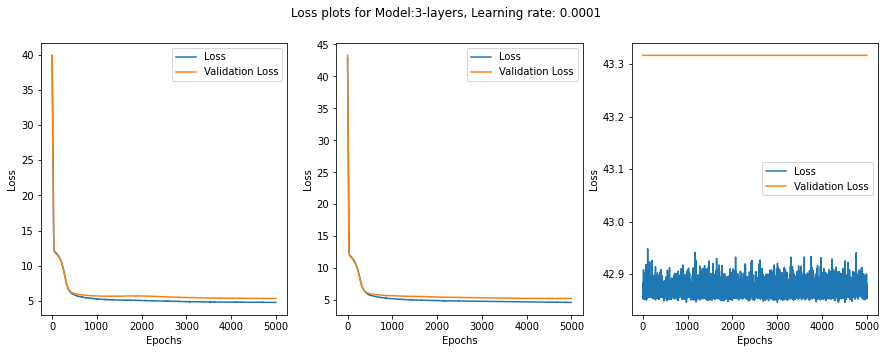

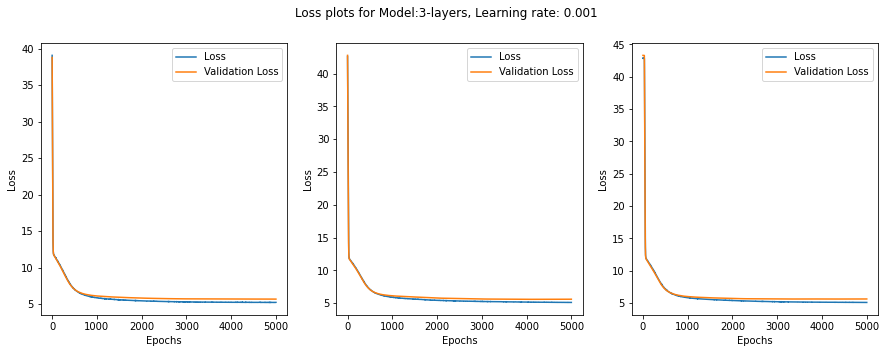

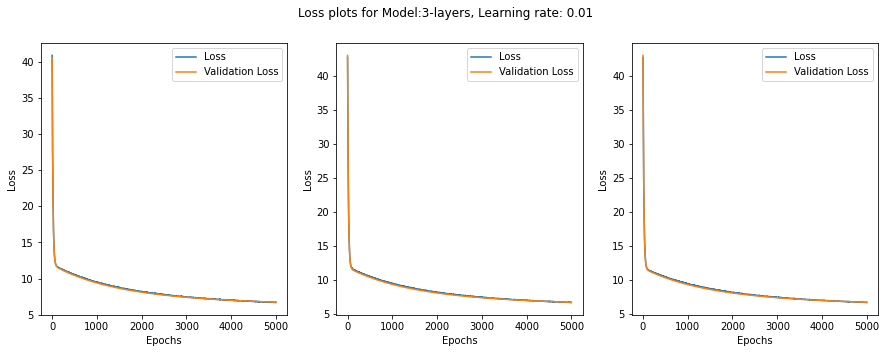

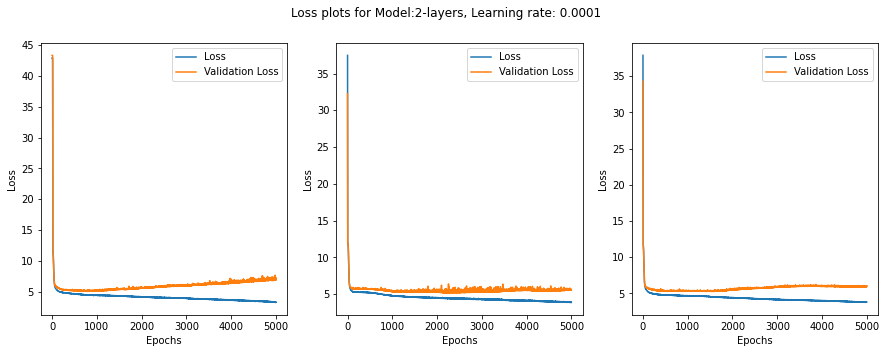

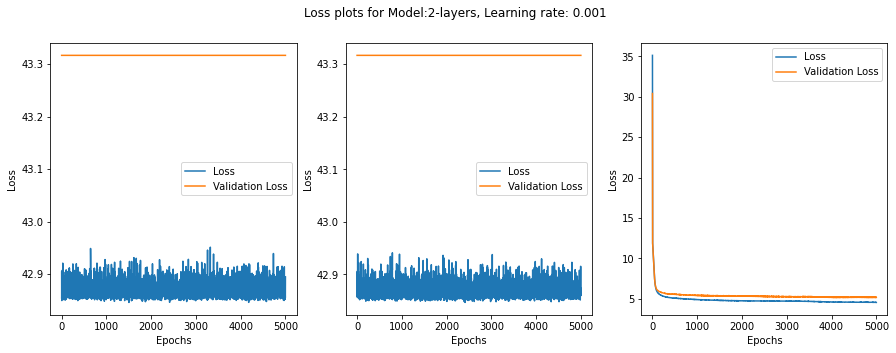

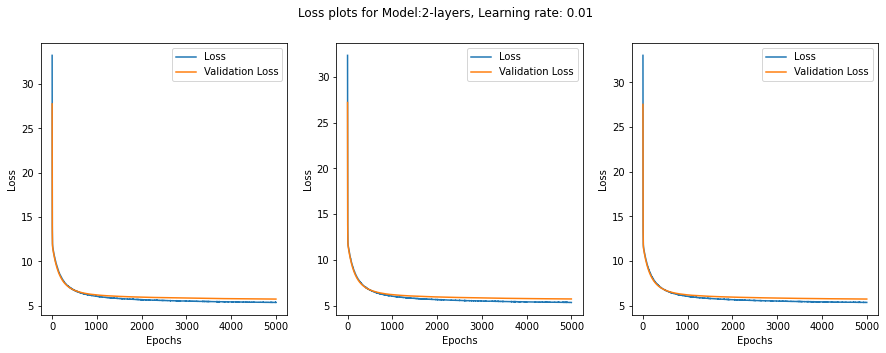

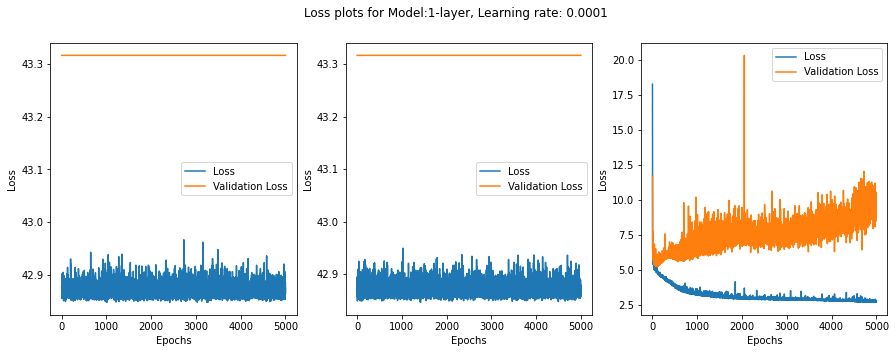

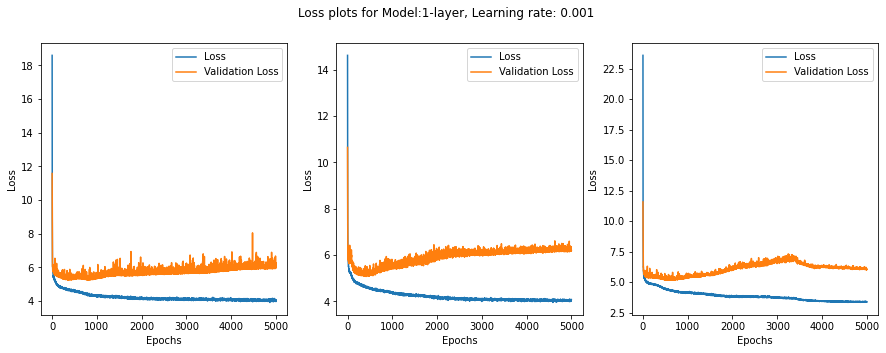

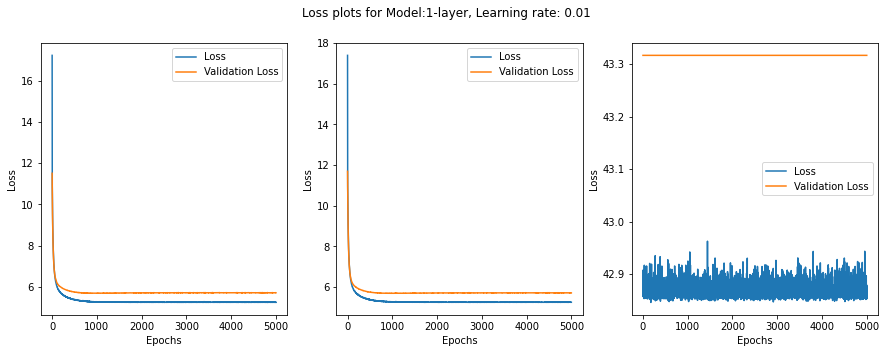

In [29]:
# Plot losses for NN models
plot_losses(histories, model_names, lrs, nr_experiments)

### Predictions
Additionally, we use all models to predict their performance on the test set. We use multiple metrics that will be defined below.
Their results will give us accurate and solid ways of comparing different models.

In [28]:
def predict_single(input_data, model):
    """
    Perform a prediction for a single dataset entry.
    
    Inputs:
        - input_data - list of processed house characteristics
        - model - PyTorch model to be used for prediction
    Returns:
        - prediction - Prediction of house price
    """
    inputs = input_data.unsqueeze(0)
    predictions = model(inputs)                
    prediction = predictions[0].detach().numpy()
    return prediction

In [91]:
def predict(test_ds, model):
    """
    Perform model predictions for a whole dataset

    Input: 
        - test_ds - Dataloader of (test) dataset
        - model - PyTorch model to be used for prediction
    Returns:
        - predictions - array of predictions
        - targets - array of true house prices
    """
    predictions = []
    targets = []

    for test_data in test_ds:
        input_data, target = test_data
        target = target.detach().numpy()
        prediction = predict_single(input_data, model)
        predictions.append(prediction)
        targets.append(target)
    predictions = np.array(predictions)*100000.0
    targets = np.array(targets)*100000.0
    return (predictions, targets)

The metrics defined below are the:

- **Mean Absolute Error (MAE) (or L1-Loss)**
$$
MAE = \frac{1}{n}\sum^n_{i=1}|\hat{y}_i - y_i|
$$

- **Mean Squared Error (MSE) (or L2-Loss)**
$$
MSE = \frac{1}{n}\sum^n_{i=1}(\hat{y}_i - y_i)^2
$$

- **Root Mean Squared Error (RMSE)**
$$
RMSE = \sqrt{\frac{1}{n}\sum^n_{i=1}(\hat{y}_i - y_i)^2}
$$

where $\hat{y}_i$ is the prediction for data entry $i$, $y_i$ is the true price for data entry $i$ and $n$ is the total number of data entries. All three metrics weigh errors differently.

In [44]:
def calculate_metrics(filepath):
    """ 
    Calculate specific metrics for prediction models

    Input:
        - filepath - location of all model parameters

    Returns:
        - sorted_names - Sorted filenames of models
        - mae - Array of MAE for all models
        - mse - Array of MSE for all models
        - rmse - Array of RMSE for all models

    """
    mae = []
    mse = []
    rmse = []
    sorted_filenames = sorted(os.listdir(filepath))
    for i in range(0, len(sorted_filenames), nr_experiments):
        files = sorted_filenames[i:i + nr_experiments]
        for filename in files:
            # Create model with different amount of layers depending on the model
            model = Net(int(filename[0]), input_size, output_size)
            model.load_state_dict(torch.load(filepath+filename))

            # Predict prices
            predictions_true, targets_true = predict(test_ds, model)

            predictions = torch.from_numpy(predictions_true.astype(float))
            targets = torch.from_numpy(targets_true.astype(float))

            # Calculate errors
            mae_error = F.l1_loss(predictions,targets)
            mse_error = F.mse_loss(predictions,targets)
            rmse_error = torch.sqrt(F.mse_loss(predictions,targets))
            
            mae.append(np.round(mae_error.detach().numpy(),2))
            mse.append(np.round(mse_error.detach().numpy(),2))
            rmse.append(np.round(rmse_error.detach().numpy(),2))
    
    sorted_names = [x.split('_best-model-parameters.pt')[0] for x in sorted_filenames]
    return sorted_names, mae, mse, rmse

The errors can be visualized in a dataframe. In the dataframe, we see that the model with 2 layers and a learning rate of 0.001 actually performed best, as it has the best values for both MSE and RMSE.

In [94]:
pd.set_option('precision', 2)
filenames, mae, mse, rmse = calculate_metrics('results/nn/')

data = {'Name': filenames, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}
metrics_df = pd.DataFrame.from_dict(data).sort_values('MAE', ascending=True)
# Highlight best models
metrics_df.style.highlight_min(color = 'limegreen', axis = 0, subset=['MAE','MSE', 'RMSE'])

,Name,MAE,MSE,RMSE
19,3-layers_0.0001_1,134054.16,56402560010.75,237492.23
14,2-layers_0.001_2,134581.68,55822818451.05,236268.53
21,3-layers_0.001_0,135047.62,59562676063.01,244054.66
18,3-layers_0.0001_0,135791.30,57321922453.31,239419.97
23,3-layers_0.001_2,136310.86,55878516083.88,236386.37
11,2-layers_0.0001_2,136379.61,57288458906.60,239350.08
10,2-layers_0.0001_1,137012.64,57972269456.58,240774.31
16,2-layers_0.01_1,137141.69,58538821128.43,241947.97
9,2-layers_0.0001_0,137426.49,58939936677.86,242775.49
7,1-layer_0.01_1,137763.15,58722625413.18,242327.52


Lastly, we plot the predictions and targets against eachother. In the ideal scenario, the two should be equal, plotting a line with a slope of 1. The closer the datapoints follow this ideal line, the better our predictions are.

In [89]:
def plot_predictions(filepath, metrics_df, loc=0):
    """
    Plot predictions of the best model against the true house prices

    Inputs:
        - filepath - Location of all trained models
        - metrics_df - dataframe with metrics of all models
        - loc - locations of the best model. This is normally 0, but can be changed when the upper model in the df is not the best
    """
    # We select the best model
    best_filename = metrics_df.iloc[loc]['Name']+'_best-model-parameters.pt'
    best_model = Net(int(best_filename[0]), input_size, output_size)
    best_model.load_state_dict(torch.load(filepath+best_filename))

    predictions_true, targets_true = predict(test_ds, best_model)

    predictions = torch.from_numpy(predictions_true.astype(float))
    targets = torch.from_numpy(targets_true.astype(float))
    plt.figure(figsize=(7,7))
    plt.scatter(targets, predictions)
    m, b = np.polyfit(targets.flatten(), predictions.flatten(), 1)

    #add linear regression line to scatterplot 
    plt.plot(targets, m*targets+b, color='red', label='Regression line')
    plt.plot(targets, targets, color='purple', label='Ideal regression line')

    plt.xlim(0,5000000)
    plt.xlabel('Targets (€)', size=11)
    plt.ylim(0,5000000)
    plt.ylabel('Predictions (€)', size=11)
    plt.title('Targets vs Predictions for best performing NN', size=13)
    plt.legend()
    plt.show()

In the plot, we see that our results follow the ideal line closely for low house prices. However, as the house prices get higher, our model deviates more and more. This makes sense as only a small amount of houses falls inside the expensive range.

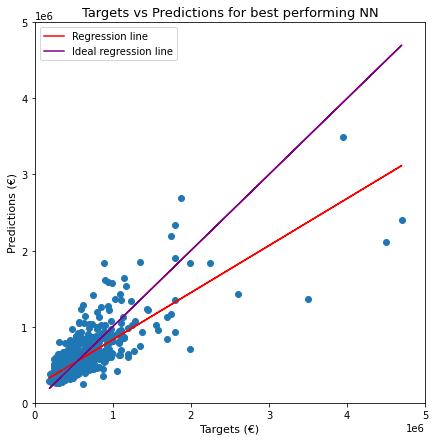

In [95]:
plot_predictions('results/nn/', metrics_df, loc=1)

## Optimizing
We have a base performance now, with an average prediction error above 100.000. This is a reasonable result, as house prices are difficult to predict. However, we still want to optimize our models and get the best results possible.

We can improve our models in multiple ways
- Adding dropout
- Using different loss function
- Training for more epochs

Improvements can also be made on different areas (that we will not go into here):
- Adding more data to the dataset
- Processing our data in a different matter

### Loss function

We start with using a different loss function. We choose to use the MAE (or L1-Loss).
We create a different class of networks, where we only edit the loss function

In [40]:
class Net_l1(Net):
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')  
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(input = out, target = targets, size_average = None, reduce = None, reduction = 'mean')    
        return {'val_loss': loss.detach()}

We see that the loss for these models is lower. Don't be fooled by this, as we use a different loss function, the outputs also mean different things. The L1 loss is naturally lower, since differences do not get squared like the L2 loss, which we used previously.

In [41]:
# initialize model and optimizer every run

model_names = ['3-layers', '2-layers', '1-layer']
epochs = 5000
lrs = [0.0001, 0.001, 0.01]
histories_l1 = []
nr_experiments = 3
for i in tqdm(range(nr_experiments), total=nr_experiments):
    for lr in lrs:
        for model_name in tqdm(model_names, total=len(model_names), leave=False):
            model = Net_l1(int(model_name[0]), input_size, output_size)
            print('Starting training of model: {0} with Lr: {1}'.format(model_name,lr))
            history = fit(epochs, lr, model, train_loader, val_loader, filename='results/nn_l1/'+model_name+'_'+str(lr)+'_'+str(i))
            histories_l1.append(history)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.0001
Epoch [50], val_loss: 4.8414, loss: 4.8226
Epoch [100], val_loss: 4.5050, loss: 4.4882
Epoch [150], val_loss: 4.1198, loss: 4.1040
Epoch [200], val_loss: 3.6358, loss: 3.6224
Epoch [250], val_loss: 2.9770, loss: 2.9642
Epoch [300], val_loss: 2.2924, loss: 2.2863
Epoch [350], val_loss: 2.0401, loss: 2.0318
Epoch [400], val_loss: 2.0060, loss: 1.9972
Epoch [450], val_loss: 1.9993, loss: 1.9931
Epoch [500], val_loss: 1.9967, loss: 1.9907
Epoch [550], val_loss: 1.9944, loss: 1.9882
Epoch [600], val_loss: 1.9921, loss: 1.9869
Epoch [650], val_loss: 1.9899, loss: 1.9850
Epoch [700], val_loss: 1.9876, loss: 1.9823
Epoch [750], val_loss: 1.9852, loss: 1.9809
Epoch [800], val_loss: 1.9827, loss: 1.9774
Epoch [850], val_loss: 1.9802, loss: 1.9754
Epoch [900], val_loss: 1.9776, loss: 1.9728
Epoch [950], val_loss: 1.9749, loss: 1.9703
Epoch [1000], val_loss: 1.9720, loss: 1.9681
Epoch [1050], val_loss: 1.9691, loss: 1.9668
Epoch [1100], val_loss

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.001
Epoch [50], val_loss: 1.9677, loss: 1.9605
Epoch [100], val_loss: 1.9071, loss: 1.9026
Epoch [150], val_loss: 1.8165, loss: 1.8118
Epoch [200], val_loss: 1.6646, loss: 1.6665
Epoch [250], val_loss: 1.5447, loss: 1.5418
Epoch [300], val_loss: 1.4933, loss: 1.4781
Epoch [350], val_loss: 1.4615, loss: 1.4349
Epoch [400], val_loss: 1.4335, loss: 1.4024
Epoch [450], val_loss: 1.4092, loss: 1.3782
Epoch [500], val_loss: 1.3940, loss: 1.3601
Epoch [550], val_loss: 1.3888, loss: 1.3454
Epoch [600], val_loss: 1.3755, loss: 1.3347
Epoch [650], val_loss: 1.3679, loss: 1.3255
Epoch [700], val_loss: 1.3613, loss: 1.3185
Epoch [750], val_loss: 1.3555, loss: 1.3132
Epoch [800], val_loss: 1.3506, loss: 1.3070
Epoch [850], val_loss: 1.3471, loss: 1.3028
Epoch [900], val_loss: 1.3452, loss: 1.3000
Epoch [950], val_loss: 1.3448, loss: 1.2982
Epoch [1000], val_loss: 1.3416, loss: 1.2955
Epoch [1050], val_loss: 1.3398, loss: 1.2933
Epoch [1100], val_loss:

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.01
Epoch [50], val_loss: 5.5691, loss: 5.5476
Epoch [100], val_loss: 5.5691, loss: 5.5474
Epoch [150], val_loss: 5.5691, loss: 5.5484
Epoch [200], val_loss: 5.5691, loss: 5.5480
Epoch [250], val_loss: 5.5691, loss: 5.5478
Epoch [300], val_loss: 5.5691, loss: 5.5486
Epoch [350], val_loss: 5.5691, loss: 5.5480
Epoch [400], val_loss: 5.5691, loss: 5.5480
Epoch [450], val_loss: 5.5691, loss: 5.5474
Epoch [500], val_loss: 5.5691, loss: 5.5483
Epoch [550], val_loss: 5.5691, loss: 5.5481
Epoch [600], val_loss: 5.5691, loss: 5.5478
Epoch [650], val_loss: 5.5691, loss: 5.5474
Epoch [700], val_loss: 5.5691, loss: 5.5480
Epoch [750], val_loss: 5.5691, loss: 5.5474
Epoch [800], val_loss: 5.5691, loss: 5.5482
Epoch [850], val_loss: 5.5691, loss: 5.5484
Epoch [900], val_loss: 5.5691, loss: 5.5477
Epoch [950], val_loss: 5.5691, loss: 5.5482
Epoch [1000], val_loss: 5.5691, loss: 5.5481
Epoch [1050], val_loss: 5.5691, loss: 5.5476
Epoch [1100], val_loss: 

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.0001
Epoch [50], val_loss: 5.5691, loss: 5.5487
Epoch [100], val_loss: 5.5691, loss: 5.5488
Epoch [150], val_loss: 5.5691, loss: 5.5483
Epoch [200], val_loss: 5.5691, loss: 5.5472
Epoch [250], val_loss: 5.5691, loss: 5.5474
Epoch [300], val_loss: 5.5691, loss: 5.5482
Epoch [350], val_loss: 5.5691, loss: 5.5487
Epoch [400], val_loss: 5.5691, loss: 5.5482
Epoch [450], val_loss: 5.5691, loss: 5.5480
Epoch [500], val_loss: 5.5691, loss: 5.5485
Epoch [550], val_loss: 5.5691, loss: 5.5474
Epoch [600], val_loss: 5.5691, loss: 5.5482
Epoch [650], val_loss: 5.5691, loss: 5.5490
Epoch [700], val_loss: 5.5691, loss: 5.5474
Epoch [750], val_loss: 5.5691, loss: 5.5484
Epoch [800], val_loss: 5.5691, loss: 5.5476
Epoch [850], val_loss: 5.5691, loss: 5.5480
Epoch [900], val_loss: 5.5691, loss: 5.5474
Epoch [950], val_loss: 5.5691, loss: 5.5480
Epoch [1000], val_loss: 5.5691, loss: 5.5466
Epoch [1050], val_loss: 5.5691, loss: 5.5482
Epoch [1100], val_loss

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.001
Epoch [50], val_loss: 1.9512, loss: 1.9482
Epoch [100], val_loss: 1.8722, loss: 1.8694
Epoch [150], val_loss: 1.7440, loss: 1.7418
Epoch [200], val_loss: 1.5867, loss: 1.5921
Epoch [250], val_loss: 1.5140, loss: 1.5027
Epoch [300], val_loss: 1.4820, loss: 1.4559
Epoch [350], val_loss: 1.4558, loss: 1.4258
Epoch [400], val_loss: 1.4361, loss: 1.4013
Epoch [450], val_loss: 1.4134, loss: 1.3825
Epoch [500], val_loss: 1.3993, loss: 1.3660
Epoch [550], val_loss: 1.3903, loss: 1.3514
Epoch [600], val_loss: 1.3789, loss: 1.3398
Epoch [650], val_loss: 1.3698, loss: 1.3314
Epoch [700], val_loss: 1.3633, loss: 1.3243
Epoch [750], val_loss: 1.3575, loss: 1.3187
Epoch [800], val_loss: 1.3557, loss: 1.3135
Epoch [850], val_loss: 1.3493, loss: 1.3096
Epoch [900], val_loss: 1.3570, loss: 1.3068
Epoch [950], val_loss: 1.3436, loss: 1.3050
Epoch [1000], val_loss: 1.3432, loss: 1.3033
Epoch [1050], val_loss: 1.3498, loss: 1.3024
Epoch [1100], val_loss:

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.01
Epoch [50], val_loss: 5.5691, loss: 5.5477
Epoch [100], val_loss: 5.5691, loss: 5.5488
Epoch [150], val_loss: 5.5691, loss: 5.5486
Epoch [200], val_loss: 5.5691, loss: 5.5480
Epoch [250], val_loss: 5.5691, loss: 5.5471
Epoch [300], val_loss: 5.5691, loss: 5.5478
Epoch [350], val_loss: 5.5691, loss: 5.5487
Epoch [400], val_loss: 5.5691, loss: 5.5481
Epoch [450], val_loss: 5.5691, loss: 5.5488
Epoch [500], val_loss: 5.5691, loss: 5.5485
Epoch [550], val_loss: 5.5691, loss: 5.5487
Epoch [600], val_loss: 5.5691, loss: 5.5473
Epoch [650], val_loss: 5.5691, loss: 5.5472
Epoch [700], val_loss: 5.5691, loss: 5.5482
Epoch [750], val_loss: 5.5691, loss: 5.5484
Epoch [800], val_loss: 5.5691, loss: 5.5477
Epoch [850], val_loss: 5.5691, loss: 5.5478
Epoch [900], val_loss: 5.5691, loss: 5.5487
Epoch [950], val_loss: 5.5691, loss: 5.5480
Epoch [1000], val_loss: 5.5691, loss: 5.5477
Epoch [1050], val_loss: 5.5691, loss: 5.5477
Epoch [1100], val_loss: 

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.0001
Epoch [50], val_loss: 4.7961, loss: 4.7822
Epoch [100], val_loss: 3.8679, loss: 3.8645
Epoch [150], val_loss: 2.2172, loss: 2.2167
Epoch [200], val_loss: 2.0333, loss: 2.0268
Epoch [250], val_loss: 2.0244, loss: 2.0201
Epoch [300], val_loss: 2.0183, loss: 2.0142
Epoch [350], val_loss: 2.0126, loss: 2.0092
Epoch [400], val_loss: 2.0072, loss: 2.0037
Epoch [450], val_loss: 2.0019, loss: 1.9997
Epoch [500], val_loss: 1.9964, loss: 1.9943
Epoch [550], val_loss: 1.9911, loss: 1.9892
Epoch [600], val_loss: 1.9858, loss: 1.9837
Epoch [650], val_loss: 1.9806, loss: 1.9791
Epoch [700], val_loss: 1.9755, loss: 1.9741
Epoch [750], val_loss: 1.9701, loss: 1.9692
Epoch [800], val_loss: 1.9647, loss: 1.9638
Epoch [850], val_loss: 1.9592, loss: 1.9587
Epoch [900], val_loss: 1.9537, loss: 1.9538
Epoch [950], val_loss: 1.9483, loss: 1.9485
Epoch [1000], val_loss: 1.9427, loss: 1.9437
Epoch [1050], val_loss: 1.9371, loss: 1.9374
Epoch [1100], val_loss

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.001
Epoch [50], val_loss: 5.5691, loss: 5.5488
Epoch [100], val_loss: 4.3475, loss: 4.3551
Epoch [150], val_loss: 2.2589, loss: 2.2487
Epoch [200], val_loss: 2.0380, loss: 2.0242
Epoch [250], val_loss: 2.0231, loss: 2.0098
Epoch [300], val_loss: 2.0227, loss: 2.0104
Epoch [350], val_loss: 2.0221, loss: 2.0095
Epoch [400], val_loss: 2.0216, loss: 2.0102
Epoch [450], val_loss: 2.0211, loss: 2.0095
Epoch [500], val_loss: 2.0205, loss: 2.0080
Epoch [550], val_loss: 2.0198, loss: 2.0080
Epoch [600], val_loss: 2.0187, loss: 2.0066
Epoch [650], val_loss: 2.0173, loss: 2.0051
Epoch [700], val_loss: 2.0154, loss: 2.0033
Epoch [750], val_loss: 2.0124, loss: 2.0004
Epoch [800], val_loss: 2.0079, loss: 1.9962
Epoch [850], val_loss: 2.0008, loss: 1.9891
Epoch [900], val_loss: 1.9897, loss: 1.9789
Epoch [950], val_loss: 1.9723, loss: 1.9617
Epoch [1000], val_loss: 1.9453, loss: 1.9362
Epoch [1050], val_loss: 1.9036, loss: 1.8961
Epoch [1100], val_loss:

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 3-layers with Lr: 0.01
Epoch [50], val_loss: 5.5691, loss: 5.5477
Epoch [100], val_loss: 5.5691, loss: 5.5477
Epoch [150], val_loss: 5.5691, loss: 5.5483
Epoch [200], val_loss: 5.5691, loss: 5.5482
Epoch [250], val_loss: 5.5691, loss: 5.5479
Epoch [300], val_loss: 5.5691, loss: 5.5481
Epoch [350], val_loss: 5.5691, loss: 5.5471
Epoch [400], val_loss: 5.5691, loss: 5.5475
Epoch [450], val_loss: 5.5691, loss: 5.5482
Epoch [500], val_loss: 5.5691, loss: 5.5484
Epoch [550], val_loss: 5.5691, loss: 5.5475
Epoch [600], val_loss: 5.5691, loss: 5.5480
Epoch [650], val_loss: 5.5691, loss: 5.5477
Epoch [700], val_loss: 5.5691, loss: 5.5475
Epoch [750], val_loss: 5.5691, loss: 5.5482
Epoch [800], val_loss: 5.5691, loss: 5.5483
Epoch [850], val_loss: 5.5691, loss: 5.5483
Epoch [900], val_loss: 5.5691, loss: 5.5479
Epoch [950], val_loss: 5.5691, loss: 5.5484
Epoch [1000], val_loss: 5.5691, loss: 5.5476
Epoch [1050], val_loss: 5.5691, loss: 5.5478
Epoch [1100], val_loss: 

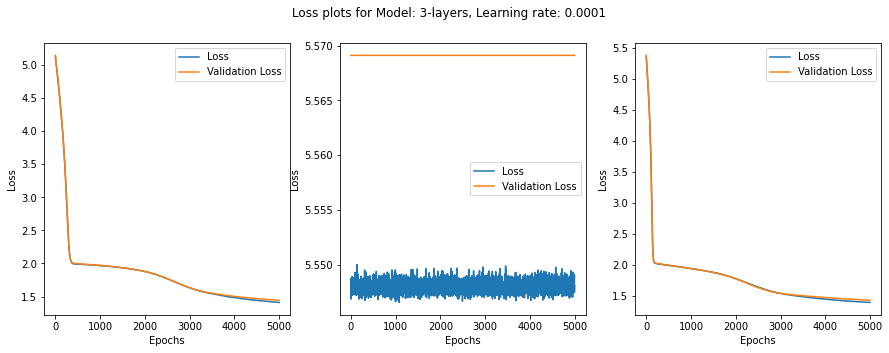

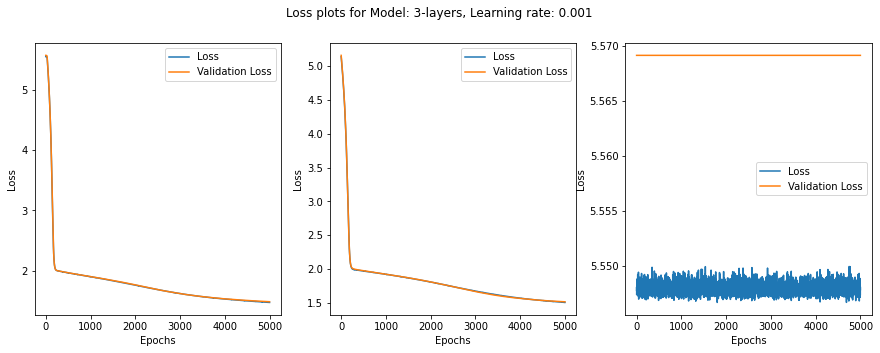

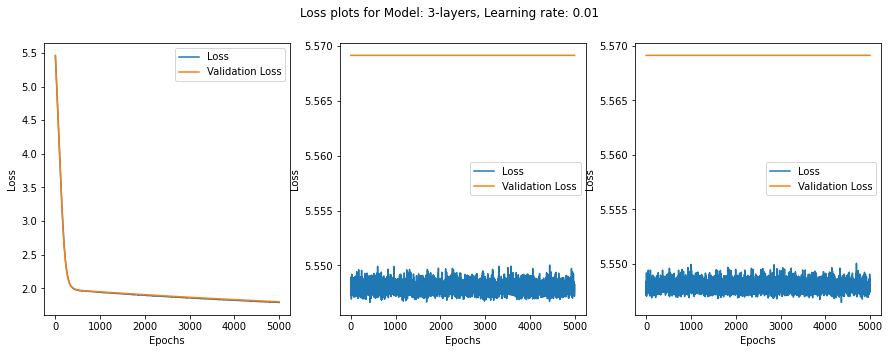

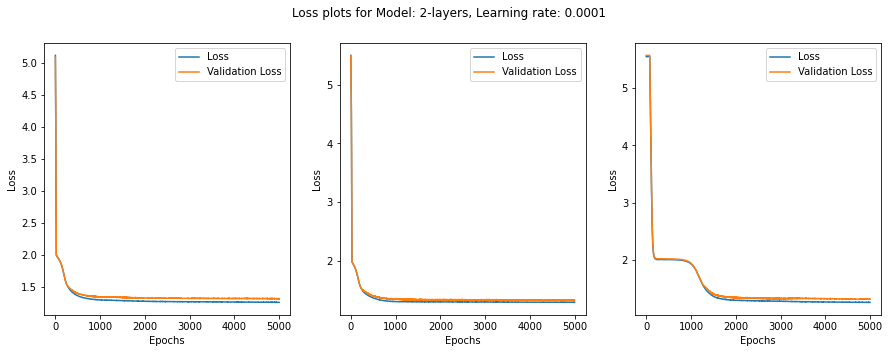

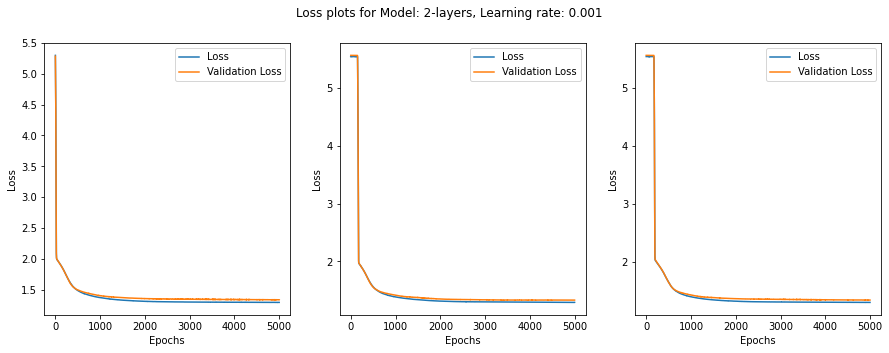

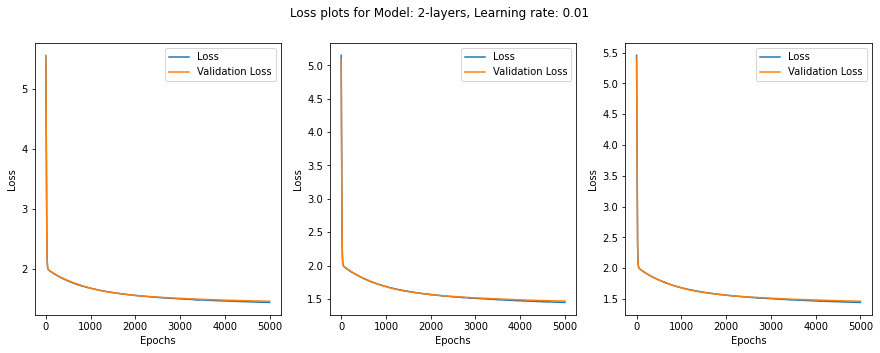

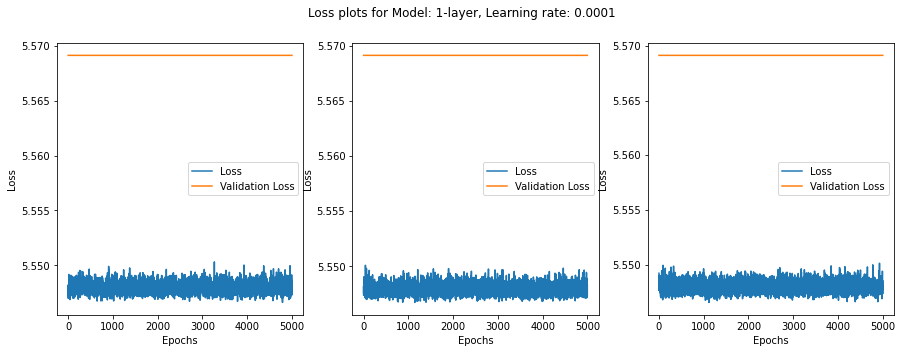

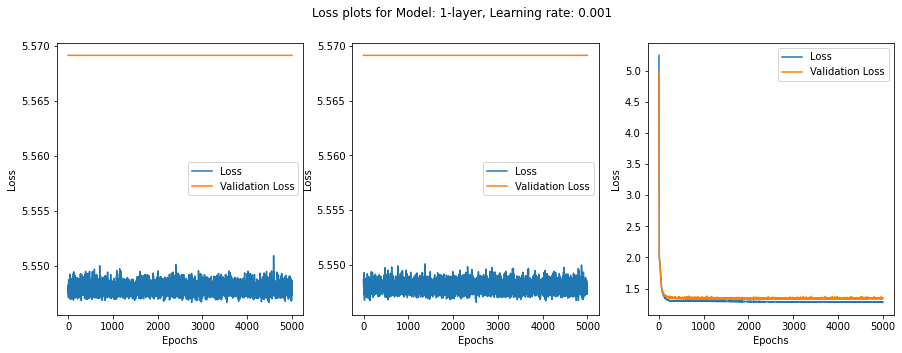

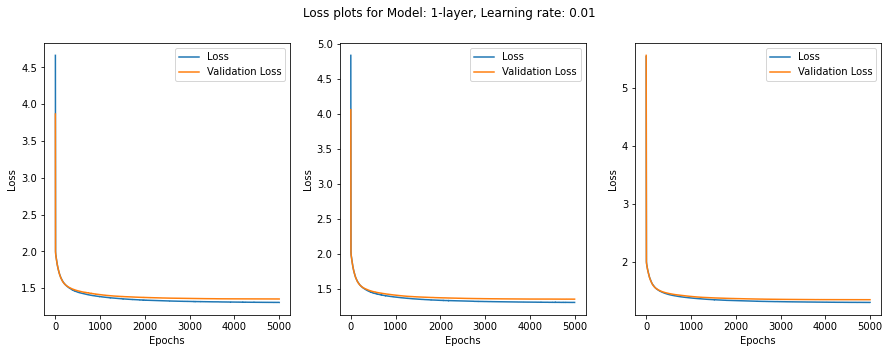

In [42]:
# Plot losses for NN models
plot_losses(histories_l1, model_names, lrs, nr_experiments)

The models trained with the MAE show similar but worse results overall. The MAE is indeed lower, but both the MSE and RMSE have worse results. The initial models with MSE loss are therefore still the best

In [47]:
pd.set_option('precision', 2)
filenames_l1, mae_l1, mse_l1, rmse_l1 = calculate_metrics('results/nn_l1/')

data_l1 = {'Name': filenames_l1, 'MAE': mae_l1, 'MSE': mse_l1, 'RMSE': rmse_l1}
metrics_df_l1 = pd.DataFrame.from_dict(data_l1).sort_values('MAE', ascending=True)
metrics_df_l1.style.highlight_min(color = 'limegreen', axis = 0, subset=['MAE','MSE', 'RMSE'])

,Name,MAE,MSE,RMSE
17,2-layers_0.01_2,131724.23,59555181000.99,244039.30
22,3-layers_0.001_1,131775.83,59203812841.17,243318.34
13,2-layers_0.001_1,131918.32,59997340225.14,244943.54
12,2-layers_0.001_0,131943.21,60918942983.22,246817.63
21,3-layers_0.001_0,132018.07,58442893794.55,241749.65
14,2-layers_0.001_2,132051.03,61230971751.85,247448.93
23,3-layers_0.001_2,133069.97,69432961333.57,263501.35
6,1-layer_0.01_0,133702.14,63406763847.32,251807.00
7,1-layer_0.01_1,133711.17,63336836238.95,251668.11
8,1-layer_0.01_2,133738.70,63305918052.60,251606.67


When we plot the predictions of the model with the best MAE, we see that indeed the predictions are worse than before.

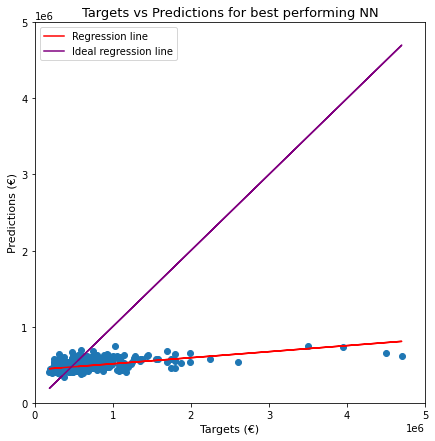

In [48]:
plot_predictions('results/nn_l1/', metrics_df_l1)

### Dropout
We try to add dropout (the turning off of random weights with a set probability) in order to optimize our models. Therefore we need to create a slightly different new network

In [50]:
class Net_dropout(Net):
    def __init__(self, layers, input_shape, output_shape):
        super(Net, self).__init__()
        self.layers = layers
        self.input_shape = input_shape
        self.output_shape = output_shape
        self.shapes = np.append(np.linspace(input_shape, output_shape,layers, endpoint=False).round(),output_shape).astype(int)
        self.fc_layers = nn.ModuleList()  
        for layer in range(layers):
            self.fc_layers.append(nn.Linear(self.shapes[layer], self.shapes[layer+1]))
        self.dropout = nn.Dropout(p=0.5)

    # x represents our data
    def forward(self, x):
        # Pass data through fc1
        for layer in range(self.layers):
            x = self.fc_layers[layer](x)
            x = F.relu(x)
            x = self.dropout(x)

        output = x
        return output

We continue trainig with the best model we trained with the MSE loss function

In [103]:
# initialize model and optimizer every run

model_name = '2-layers'
epochs = 5000
lr = 0.001
histories_drop = []
nr_experiments = 3
for i in tqdm(range(nr_experiments), total=nr_experiments):
    model = Net_dropout(2, input_size, output_size)
    print('Starting training of model: {0} with Lr: {1}'.format(model_name,lr))
    history = fit(epochs, lr, model, train_loader, val_loader, filename='results/nn_drop/'+model_name+'_'+str(lr)+'_'+str(i))
    histories_drop.append(history)

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 2-layers with Lr: 0.001
Epoch [50], val_loss: 25.9256, loss: 26.6260
Epoch [100], val_loss: 27.7536, loss: 25.8531
Epoch [150], val_loss: 24.2308, loss: 25.8067
Epoch [200], val_loss: 24.7367, loss: 25.6036
Epoch [250], val_loss: 24.3336, loss: 24.5991
Epoch [300], val_loss: 28.4681, loss: 24.1787
Epoch [350], val_loss: 24.6156, loss: 24.0891
Epoch [400], val_loss: 25.4533, loss: 25.5859
Epoch [450], val_loss: 24.3578, loss: 24.8679
Epoch [500], val_loss: 26.7668, loss: 23.2381
Epoch [550], val_loss: 25.3435, loss: 25.2488
Epoch [600], val_loss: 27.2542, loss: 25.2652
Epoch [650], val_loss: 24.3023, loss: 23.8084
Epoch [700], val_loss: 24.8492, loss: 24.2652
Epoch [750], val_loss: 23.3763, loss: 24.3003
Epoch [800], val_loss: 26.0658, loss: 25.7127
Epoch [850], val_loss: 24.0490, loss: 25.7112
Epoch [900], val_loss: 25.8018, loss: 25.1842
Epoch [950], val_loss: 23.6425, loss: 24.7491
Epoch [1000], val_loss: 26.3751, loss: 24.7639
Epoch [1050], val_loss: 22.1

From the loss plots, we see that the performance is less stable (graph is more spiky), but all models have reached a similar performance

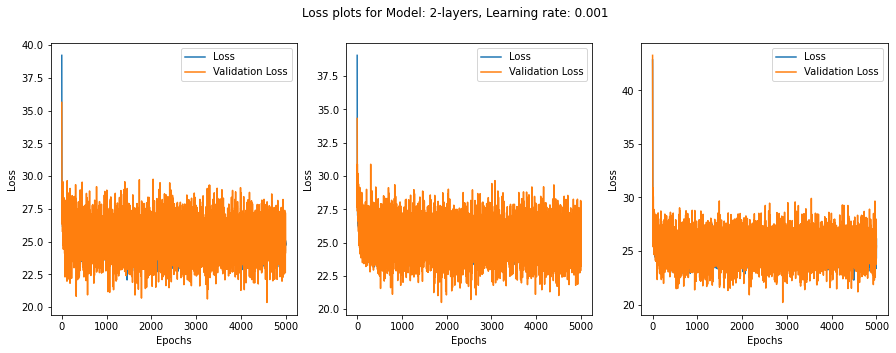

In [104]:
# Plot losses for NN models with dropout
plot_losses(histories_drop, model_names=['2-layers'], nr_experiments=nr_experiments, learning_rates=[0.001])

The metrics show that these models are far worse than models that we have trained before. This means that all the data that we are using is  necessary for good predictions.

In [105]:
filenames_drop, mae_drop, mse_drop, rmse_drop = calculate_metrics('results/nn_drop/')

data_drop = {'Name': filenames_drop, 'MAE': mae_drop, 'MSE': mse_drop, 'RMSE': rmse_drop}
metrics_df_drop = pd.DataFrame.from_dict(data_drop).sort_values('MAE', ascending=True)
metrics_df_drop.style.highlight_min(color = 'limegreen', axis = 0, subset=['MAE','MSE', 'RMSE'])

,Name,MAE,MSE,RMSE
1,2-layers_0.001_1,276767.53,170202740804.50,412556.35
2,2-layers_0.001_2,277522.50,169834897145.79,412110.30
0,2-layers_0.001_0,278488.36,169430502524.37,411619.37


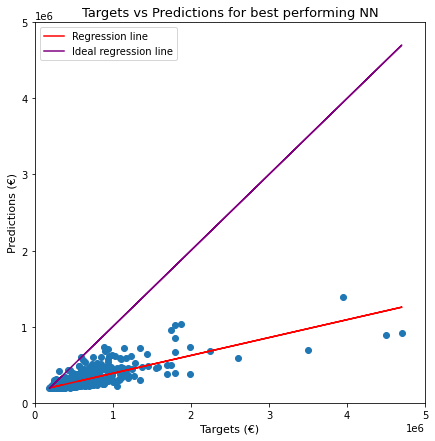

In [106]:
plot_predictions('results/nn_drop/', metrics_df_drop)

### Epochs
Finally, we see what happens when we train the same model for double the amount of epochs that we did before. This could improve predictions, or make the model more adapted to the training data and not to the test data, causing worse predictions

In [107]:
# initialize model and optimizer every run

model_name = '2-layers'
epochs = 10000
lr = 0.001
histories_epoch = []
nr_experiments = 3
for i in tqdm(range(nr_experiments), total=nr_experiments):
    model = Net(2, input_size, output_size)
    print('Starting training of model: {0} with Lr: {1}'.format(model_name,lr))
    history = fit(epochs, lr, model, train_loader, val_loader, filename='results/nn_epoch/'+model_name+'_'+str(lr)+'_'+str(i))
    histories_epoch.append(history)

  0%|          | 0/3 [00:00<?, ?it/s]

Starting training of model: 2-layers with Lr: 0.001
Epoch [50], val_loss: 6.8430, loss: 6.9231
Epoch [100], val_loss: 6.0619, loss: 5.8382
Epoch [150], val_loss: 5.9001, loss: 5.5690
Epoch [200], val_loss: 5.8084, loss: 5.4192
Epoch [250], val_loss: 5.7434, loss: 5.3148
Epoch [300], val_loss: 5.7234, loss: 5.2558
Epoch [350], val_loss: 5.7102, loss: 5.2069
Epoch [400], val_loss: 5.7076, loss: 5.1776
Epoch [450], val_loss: 5.7145, loss: 5.1508
Epoch [500], val_loss: 5.7156, loss: 5.1339
Epoch [550], val_loss: 5.7218, loss: 5.1227
Epoch [600], val_loss: 5.7265, loss: 5.0902
Epoch [650], val_loss: 5.7123, loss: 5.0761
Epoch [700], val_loss: 5.7213, loss: 5.0606
Epoch [750], val_loss: 5.7035, loss: 5.0400
Epoch [800], val_loss: 5.6808, loss: 5.0276
Epoch [850], val_loss: 5.6589, loss: 5.0018
Epoch [900], val_loss: 5.6340, loss: 5.0022
Epoch [950], val_loss: 5.6175, loss: 4.9744
Epoch [1000], val_loss: 5.6075, loss: 4.9559
Epoch [1050], val_loss: 5.5802, loss: 4.9399
Epoch [1100], val_loss:

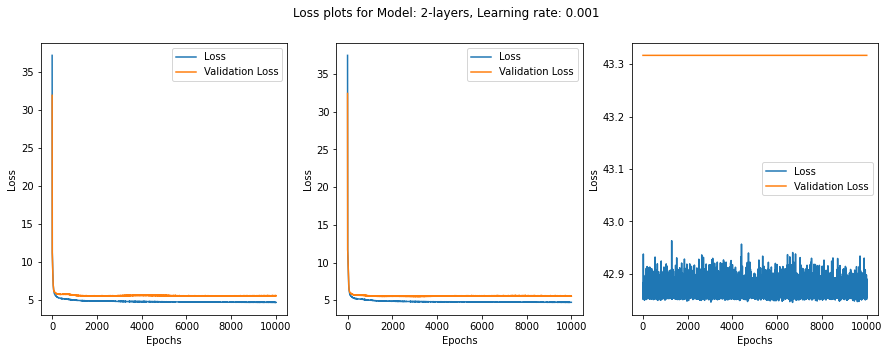

In [108]:
# Plot losses for NN models
plot_losses(histories_epoch, model_names=['2-layers'], nr_experiments=nr_experiments, learning_rates=[0.001])

The results are very close, but we see that the model we orginally trained still has a slightly better performance. Therefore increasing the amount of epochs did not work. We were already at a optimum.

In [111]:
filenames_epoch, mae_epoch, mse_epoch, rmse_epoch = calculate_metrics('results/nn_epoch/')

data_epoch = {'Name': filenames_epoch, 'MAE': mae_epoch, 'MSE': mse_epoch, 'RMSE': rmse_epoch}
metrics_df_epoch = pd.DataFrame.from_dict(data_epoch).sort_values('MAE', ascending=True)
metrics_df_epoch.style.highlight_min(color = 'limegreen', axis = 0, subset=['MAE','MSE', 'RMSE'])

,Name,MAE,MSE,RMSE
0,2-layers_0.001_0,133626.50,56408053801.27,237503.80
1,2-layers_0.001_1,135326.34,55834987345.96,236294.28
2,2-layers_0.001_2,559335.27,464719391868.29,681703.30


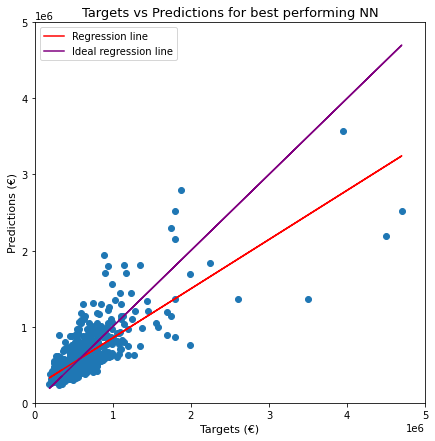

In [112]:
plot_predictions('results/nn_epoch/', metrics_df_epoch)